
# 1D Forward Simulation for a Single Sounding

Here we use the module *simpeg.electromangetics.frequency_domain_1d* to predict
frequency domain data for a single sounding over a 1D layered Earth.
In this tutorial, we focus on the following:

    - Defining receivers, sources and the survey
    - How to predict total field, secondary field or ppm data
    - The units of the model and resulting data
    - Defining and running the 1D simulation for a single sounding

Our survey geometry consists of a vertical magnetic dipole source
located 30 m above the Earth's surface. The receiver is offset
10 m horizontally from the source.


## Import Modules




In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from discretize import TensorMesh

from simpeg import maps
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg.utils import plot_1d_layer_model

plt.rcParams.update({"font.size": 16})
write_output = False

# sphinx_gallery_thumbnail_number = 2

## Create Survey

Here we demonstrate a general way to define the receivers, sources and survey.
For this tutorial, the source is a vertical magnetic dipole that will be used
to simulate data at a number of frequencies. The receivers measure real and
imaginary ppm data.




In [2]:
# Frequencies being observed in Hz
frequencies = np.array([382, 1822, 7970, 35920, 130100], dtype=float)

# Define a list of receivers. The real and imaginary components are defined
# as separate receivers.
receiver_location = np.array([10.0, 0.0, 30.0])
receiver_orientation = "z"  # "x", "y" or "z"
data_type = "ppm"  # "secondary", "total" or "ppm"

receiver_list = []
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="real",
    )
)
receiver_list.append(
    fdem.receivers.PointMagneticFieldSecondary(
        receiver_location,
        orientation=receiver_orientation,
        data_type=data_type,
        component="imag",
    )
)

# Define the source list. A source must be defined for each frequency.
source_location = np.array([0.0, 0.0, 30.0])
source_orientation = "z"  # "x", "y" or "z"
moment = 1.0  # dipole moment

source_list = []
for freq in frequencies:
    source_list.append(
        fdem.sources.MagDipole(
            receiver_list=receiver_list,
            frequency=freq,
            location=source_location,
            orientation=source_orientation,
            moment=moment,
        )
    )

# Define a 1D FDEM survey
survey = fdem.survey.Survey(source_list)

## Defining a 1D Layered Earth Model

Here, we define the layer thicknesses and electrical conductivities for our
1D simulation. If we have N layers, we define N electrical conductivity
values and N-1 layer thicknesses. The lowest layer is assumed to extend to
infinity. If the Earth is a halfspace, the thicknesses can be defined by
an empty array, and the physical property values by an array of length 1.

In this case, we have a more conductive layer within a background halfspace.
This can be defined as a 3 layered Earth model.




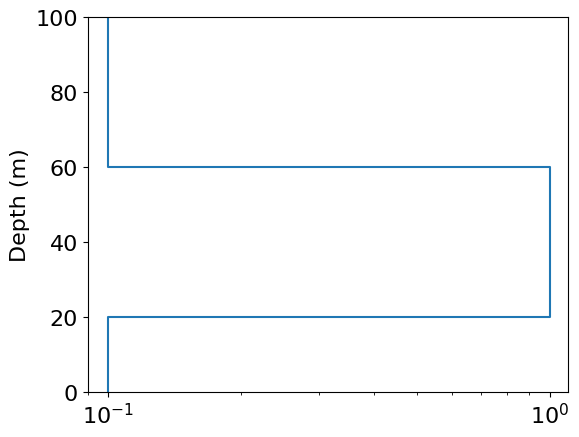

In [3]:
# Physical properties
background_conductivity = 1e-1
layer_conductivity = 1e0

# Layer thicknesses
thicknesses = np.array([20.0, 40.0])
n_layer = len(thicknesses) + 1

# physical property model (conductivity model)
model = background_conductivity * np.ones(n_layer)
model[1] = layer_conductivity

# Define a mapping from model parameters to conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

# Plot conductivity model
thicknesses_for_plotting = np.r_[thicknesses, 40.0]
mesh_for_plotting = TensorMesh([thicknesses_for_plotting])

fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
plot_1d_layer_model(thicknesses_for_plotting, model, ax=ax, show_layers=False)
plt.gca().invert_yaxis()

## Define the Forward Simulation, Predict Data and Plot

Here we define the simulation and predict the 1D FDEM sounding data.
The simulation requires the user define the survey, the layer thicknesses
and a mapping from the model to the conductivities of the layers.

When using the *simpeg.electromagnetics.frequency_domain_1d* module,
predicted data are organized by source, then by receiver, then by frequency.




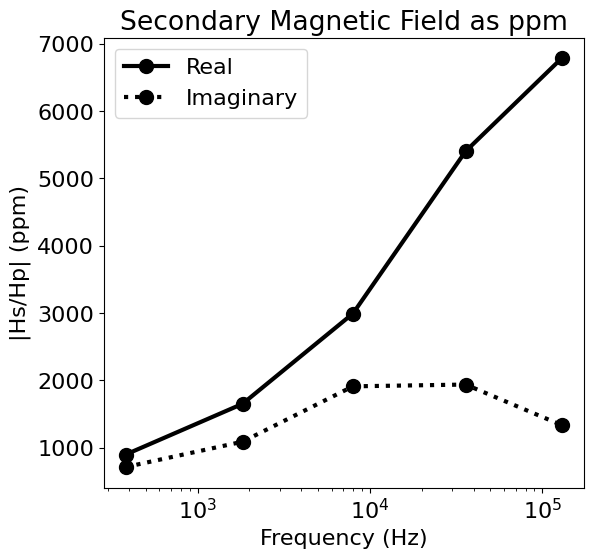

In [4]:
# Define the simulation
simulation = fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
)

# Predict sounding data
dpred = simulation.dpred(model)

# Plot sounding data
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.semilogx(frequencies, np.abs(dpred[0::2]), "k-o", lw=3, ms=10)
ax.semilogx(frequencies, np.abs(dpred[1::2]), "k:o", lw=3, ms=10)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title("Secondary Magnetic Field as ppm")
ax.legend(["Real", "Imaginary"])

## Optional: Export Data

Write the predicted data. Note that noise has been added.




In [5]:
if write_output:
    dir_path = os.path.dirname(__file__).split(os.path.sep)
    dir_path.extend(["outputs"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    np.random.seed(222)
    noise = 0.05 * np.abs(dpred) * np.random.randn(len(dpred))
    dpred += noise

    fname = dir_path + "em1dfm_data.txt"
    np.savetxt(
        fname,
        np.c_[frequencies, dpred[0 : len(frequencies)], dpred[len(frequencies) :]],
        fmt="%.4e",
        header="FREQUENCY HZ_REAL HZ_IMAG",
    )